In [1]:
import networkx as nx
import csv
from matplotlib import pyplot as plt
import numpy as np
import json

In [2]:
INTRA = 1
INTER = 2
NODE_ATTR = "class"
EDGE_ATTR = "type"

## Labels reading

In [3]:
labels = dict()
with open('dataset/journal.pone.0023176.s005.TXT') as label_f:
    raw_labels = csv.reader(label_f, delimiter='\t')
    for r in raw_labels:
        assert int(r[0]) not in labels 
        labels[int(r[0])] = r[1]

#### Classes' name

In [4]:
CLASSES = set(labels.values())

## Functions 

In [79]:
def extract_subgraphs(origin_graph, classes=CLASSES, duration=0):
    class_graphs = dict()
    durations = {tuple(sorted(e)): d for e, d in nx.get_edge_attributes(origin_graph, 'duration').items()}

    for cl in classes:
        if cl == "teachers":
            continue
        
        class_members = [n for n, att in origin_graph.nodes(data=True) if att[NODE_ATTR] == cl]

        neighbours = list()
        for m in class_members:
            neighbours.extend(list(nx.ego_graph(origin_graph, m).nodes))
    
        stakeholders = class_members + neighbours
        stakeholders = filter(lambda x: origin_graph.nodes[x][NODE_ATTR] != "teachers", stakeholders)
        class_graphs[cl] = nx.Graph(nx.subgraph(origin_graph, list(stakeholders))) # make a copy of the subgraph
    
        edge_labels = {tuple(sorted(e)) : INTRA if(e[0] in class_members and e[1] in class_members) else INTER for e in class_graphs[cl].edges}
    
        # Checks
        graph_members_edges = list(map(lambda x: tuple(sorted(x)), nx.subgraph(origin_graph, list(class_members)).edges))
        INTRA_edges = [e for e, att in edge_labels.items() if att == INTRA]
        INTER_edges = [e for e, att in edge_labels.items() if att == INTER]
        edges = list(map(lambda x: tuple(sorted(x)), class_graphs[cl].edges))
    
        # graph_members_edges = INTRA_edges
        assert(len(set(graph_members_edges) - set(INTRA_edges)) == 0 and len(graph_members_edges) == len(INTRA_edges))
    
        # INTER_edges = edges - INTRA_edges
        assert(len(set(INTER_edges) - (set(edges) - set(INTRA_edges))) == 0 and len(INTER_edges) == len(edges) - len(INTRA_edges))
    
        nx.set_edge_attributes(class_graphs[cl], edge_labels, EDGE_ATTR)
        assert(len(nx.get_edge_attributes(class_graphs[cl], EDGE_ATTR).values()) == len(edge_labels))
    
        # Remove edges which are not at least linked to a member of the class
        edges_to_remove = [tuple(sorted(e)) for e in class_graphs[cl].edges if e[0] not in class_members and e[1] not in class_members]
        previous_edges_size = len(class_graphs[cl].edges)
        class_graphs[cl].remove_edges_from(edges_to_remove)
        assert(len(class_graphs[cl].edges) == previous_edges_size - len(edges_to_remove))
        
        
        if duration != 0:
            assert(len(list(nx.isolates(class_graphs[cl]))) == 0) # Check there is no isolted nodes
            edges_to_remove = filter(lambda x: durations[tuple(sorted(x))] < duration, class_graphs[cl].edges)
            edges_to_remove = list(map(lambda x: tuple(sorted(x)), edges_to_remove))
            previous_edges_size = len(class_graphs[cl].edges)
            class_graphs[cl].remove_edges_from(edges_to_remove)
            assert(len(class_graphs[cl].edges) == previous_edges_size - len(edges_to_remove))
            isolates = list(nx.isolates(class_graphs[cl]))
            class_graphs[cl].remove_nodes_from(isolates)
            assert(len(list(nx.isolates(class_graphs[cl]))) == 0) # Check there is no isolted nodes
            
    return class_graphs

def compute_stats(graphs):
    output = dict()
    for cl, graph in graphs.items():
        in_nodes = sum([1 for _, att in graph.nodes(data=True) if att[NODE_ATTR] == cl])
        out_nodes = sum([1 for _, att in graph.nodes(data=True) if att[NODE_ATTR] != cl])
        assert(in_nodes + out_nodes == len(graph.nodes))
        
        line_graph = nx.line_graph(graph)
        
        edges_attr = {tuple(sorted(e)): att for e, att in nx.get_edge_attributes(graph, EDGE_ATTR).items()}
        
        stats = np.zeros(3)
        neighbourhoods = nx.to_dict_of_lists(line_graph)
        
        nodes = list(line_graph.nodes)
        for node in nodes:
            ego_state = edges_attr[node]
            for n in neighbourhoods[node]:
                label = edges_attr[n]
                idx = label + ego_state - 2 # 0 : 1 + 1 - 2, 1 : 1 + 2 - 1, 2 : 2 + 2 - 2
                stats[idx] += 1
        stats = stats / 2
        
        neighbourhoods_total_size = sum(len(neigh) for _, neigh in neighbourhoods.items())
        assert(len(line_graph.edges) == stats.sum())
        assert(neighbourhoods_total_size  / 2 == stats.sum()) # check total interactions
        
        team_stats = dict()
        team_stats["y_obs"] = list(stats)
        team_stats["size"] = [in_nodes, out_nodes]
        output[cl] = team_stats
    return output

## 1$^{st}$ graph : contacts during the day 1 in a primary school

#### File reading & importation

In [6]:
day1 = nx.read_gml(path="dataset/journal.pone.0023176.s003.GML", label=None)

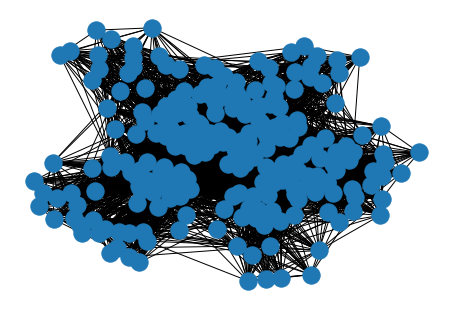

In [14]:
nx.draw(day1)
plt.show()

#### Check every node has is associated to a `class`

In [10]:
assert(all(n in labels for n in day1.nodes))

#### Set `class` attributes 

In [11]:
nx.set_node_attributes(day1, labels, NODE_ATTR)

### Extract subgraphs representing contacts/intercations by class
For every sub-graph :
* Teachers are removed
* Edges which are not connected to at least one member of the class are removed
* `NODE_ATTR` encodes  affiliation to a class
* `EDGE_ATTR`encodes the edge type (whether it connects two nodes of the given class or bridges with another class)  

In [51]:
subgraphs_day1 = extract_subgraphs(day1, duration=0)

### Compute the sufficiant statistics

In [59]:
stats_day1 = compute_stats(subgraphs_day1)

In [60]:
stats_day1

{'cpb': {'y_obs': [6586.0, 15679.0, 15215.0], 'size': [25, 136]},
 'ce1b': {'y_obs': [5409.0, 12644.0, 12889.0], 'size': [25, 125]},
 'ce2a': {'y_obs': [4623.0, 16701.0, 19750.0], 'size': [23, 157]},
 'cm1a': {'y_obs': [3804.0, 10144.0, 10070.0], 'size': [21, 125]},
 'ce1a': {'y_obs': [2975.0, 8387.0, 10149.0], 'size': [22, 137]},
 'cpa': {'y_obs': [4423.0, 15812.0, 18100.0], 'size': [22, 153]},
 'cm1b': {'y_obs': [3890.0, 10266.0, 10111.0], 'size': [22, 140]},
 'cm2b': {'y_obs': [4751.0, 15610.0, 17136.0], 'size': [23, 133]},
 'cm2a': {'y_obs': [3894.0, 12308.0, 13499.0], 'size': [22, 137]},
 'ce2b': {'y_obs': [3625.0, 15534.0, 22243.0], 'size': [21, 170]}}

In [19]:
with open('primary_school_day1.json', 'w') as file_day1:
    json.dump(stats_day1, file_day1)

### Only keep log term contacts (more than 2 minutes)

In [80]:
subgraphs_long_day1 = extract_subgraphs(day1, duration=120)

In [81]:
stats_long_day1 = compute_stats(subgraphs_long_day1)

In [78]:
stats_long_day1

{'cpb': {'y_obs': [4134.0, 1947.0, 474.0], 'size': [25, 36]},
 'ce1b': {'y_obs': [1739.0, 1165.0, 344.0], 'size': [25, 45]},
 'ce2a': {'y_obs': [1324.0, 1207.0, 464.0], 'size': [23, 42]},
 'cm1a': {'y_obs': [2201.0, 1138.0, 292.0], 'size': [21, 35]},
 'ce1a': {'y_obs': [543.0, 648.0, 352.0], 'size': [22, 37]},
 'cpa': {'y_obs': [2021.0, 1394.0, 431.0], 'size': [22, 45]},
 'cm1b': {'y_obs': [1079.0, 572.0, 202.0], 'size': [22, 25]},
 'cm2b': {'y_obs': [1655.0, 1455.0, 510.0], 'size': [23, 41]},
 'cm2a': {'y_obs': [1287.0, 950.0, 331.0], 'size': [22, 26]},
 'ce2b': {'y_obs': [1645.0, 1230.0, 381.0], 'size': [21, 38]}}

In [95]:
with open('primary_school_long_day1.json', 'w') as file_long_day1:
    json.dump(stats_long_day1, file_long_day1)

## 2$^{nd}$ graph : contacts during the day 2 in a primary school

In [85]:
day2 = nx.read_gml(path="dataset/journal.pone.0023176.s004.GML", label=None)

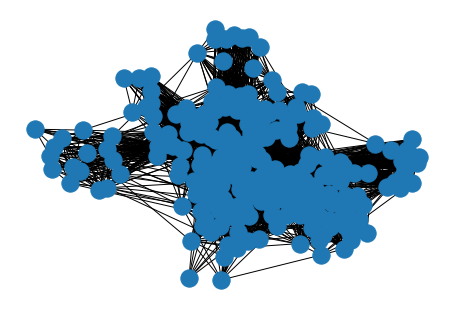

In [86]:
nx.draw(day2)
plt.show()

#### Check every node has is associated to a `class`

In [87]:
assert(all(n in labels for n in day2.nodes))

#### Set `class` attributes

In [88]:
nx.set_node_attributes(day2, labels, NODE_ATTR)

### Extract subgraphs representing contacts/intercations by class
For every sub-graph :
* Teachers are removed
* Edges which are not connected to at least one member of the class are removed
* `NODE_ATTR` encodes  affiliation to a class
* `EDGE_ATTR`encodes the edge type (whether it connects two nodes of the given class or bridges with another class)  

In [89]:
subgraphs_day2 = extract_subgraphs(day2)

In [90]:
stats_day2 = compute_stats(subgraphs_day2)

In [91]:
with open('primary_school_day2.json', 'w') as file_day2:
    json.dump(stats_day2, file_day2)

### Only keep log term contacts (more than 2 minutes)

In [92]:
subgraphs_long_day2 = extract_subgraphs(day2, duration=120)

In [93]:
stats_long_day2 = compute_stats(subgraphs_long_day2)

In [94]:
stats_long_day2

{'cpb': {'y_obs': [3694.0, 1682.0, 344.0], 'size': [25, 50]},
 'ce1b': {'y_obs': [2672.0, 1825.0, 601.0], 'size': [26, 41]},
 'ce2a': {'y_obs': [2472.0, 2488.0, 1050.0], 'size': [23, 40]},
 'cm1a': {'y_obs': [904.0, 1003.0, 475.0], 'size': [21, 37]},
 'ce1a': {'y_obs': [3556.0, 2050.0, 672.0], 'size': [23, 45]},
 'cpa': {'y_obs': [1657.0, 876.0, 290.0], 'size': [23, 43]},
 'cm1b': {'y_obs': [396.0, 284.0, 191.0], 'size': [21, 23]},
 'cm2b': {'y_obs': [1733.0, 1141.0, 336.0], 'size': [23, 37]},
 'cm2a': {'y_obs': [2301.0, 1108.0, 271.0], 'size': [21, 26]},
 'ce2b': {'y_obs': [2916.0, 2433.0, 1018.0], 'size': [21, 46]}}

In [96]:
with open('primary_school_long_day2.json', 'w') as file_long_day2:
    json.dump(stats_long_day2, file_long_day2)